# Part 1 - Scraping of Lastfm data and first exploration

## Scraping of data

In order to get my personal data from LastFm, the easiest way is to use their official REST API. 

Their API offers multiples functions to request data, either artists, tracks, labels, recent tracks.


In [1]:
import requests 
import numpy as np
import time

#Enter Username to scrap
username='saadadr'

#Enter API credentials
api_key='################'

We'll use user.getrecenttracks fonction which gives the recent 200 played tracks for each page. That means we'll need to loop over the total pages that constitues the scrobbles in order to scrap all our listening history.

In [2]:
# Function gets username and page name and returns the 200 scrobbles in a page for a user
def get_listening_data(username,api_key,page):
    link='http://ws.audioscrobbler.com/2.0/'
    params={'method':'user.getrecenttracks',
        'user':username,
        'api_key':api_key,
        'page':page,
        'limit':200,
        'format':'json'}
    return requests.get(link,params).json()

In [107]:
#Function that prints the total number of scrobbles and pages to scrap.
#Then proceeds to scrap all the scrobbles.
#The data retained are Artist, Artist_MBID, name, album, date
def scrap_data(username,api_key):
    req = get_listening_data(username,api_key,1)
    
    print ('Total scrobbles  : %s' % str(req['recenttracks']['@attr']['total']))
    
    total_pages=req['recenttracks']['@attr']['totalPages']
    print ('Total pages to scrap : %s' % str(total_pages))
    
    result= []
    #for page in range(1,int(total_pages)+1):
    for page in range(1,int(total_pages)+1):
        result_req=get_listening_data(username,api_key,page)
        if page%20==0:
            print ('Scraping page %s of %s' % (str(page),str(total_pages)))
        
        for track in result_req['recenttracks']['track'] :
            track_data={}
            track_data['artist']=track['artist']['#text']
            track_data['artist_mbid']=track['artist']['mbid']
            track_data['name']=track['name']
            track_data['album']=track['album']['#text']
            track_data['album_mbid']=track['album']['mbid']
            track_data['date']=track['date']['#text']
            track_data['date_uts']=track['date']['uts']
            #track_data['album']=track['artist']['#text']
            track_data['url']=track['url']
            result.append(track_data)
    
    return result

In [109]:
data=scrap_data(username,api_key)

Total scrobbles  : 92763
Total pages to scrap : 464
Scraping page 20 of 464
Scraping page 40 of 464
Scraping page 60 of 464
Scraping page 80 of 464
Scraping page 100 of 464
Scraping page 120 of 464
Scraping page 140 of 464
Scraping page 160 of 464
Scraping page 180 of 464
Scraping page 200 of 464
Scraping page 220 of 464
Scraping page 240 of 464
Scraping page 260 of 464
Scraping page 280 of 464
Scraping page 300 of 464
Scraping page 320 of 464
Scraping page 340 of 464
Scraping page 360 of 464
Scraping page 380 of 464
Scraping page 400 of 464
Scraping page 420 of 464
Scraping page 440 of 464
Scraping page 460 of 464


## Data Cleaning and exploration

We start by transforming our json object into a pandas dataframe with json_normalize().

We replace empty values with NaN.


In [110]:
import pandas as pd
from pandas.io.json import json_normalize

In [111]:
df = json_normalize(data)
df= df.replace(r'', np.nan, regex=True)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92763 entries, 0 to 92762
Data columns (total 8 columns):
album          91774 non-null object
album_mbid     40041 non-null object
artist         92763 non-null object
artist_mbid    82416 non-null object
date           92763 non-null object
date_uts       92763 non-null object
name           92763 non-null object
url            92763 non-null object
dtypes: object(8)
memory usage: 5.7+ MB


We see that we have a lot of scrobble entries without an artist or an album MBID either because the artist is unknown and doesn't have one in the musicbrainz database or because last fm doesn't have this data. That is something we'll deal with in the next parts.

Overview of data.

In [113]:
df.tail()

,album,album_mbid,artist,artist_mbid,date,date_uts,name,url
92758,Blood Bank,045bd22e-b181-4b67-8fda-dbb47a66cef6,Bon Iver,437a0e49-c6ae-42f6-a6c1-84f25ed366bc,"01 Nov 2012, 15:36",1351784179,Blood Bank,https://www.last.fm/music/Bon+Iver/_/Blood+Bank
92759,Tourist History [Promo],NaN,Two Door Cinema Club,6f1de078-6684-4792-820d-2ffad64c15ed,"01 Nov 2012, 08:54",1351760091,What You Know,https://www.last.fm/music/Two+Door+Cinema+Club...
92760,The 2nd Law,e3c0e7c7-df7c-4b51-9894-e45d1480e7b5,Muse,fd857293-5ab8-40de-b29e-55a69d4e4d0f,"31 Oct 2012, 11:47",1351684070,Big Freeze,https://www.last.fm/music/Muse/_/Big+Freeze
92761,An Awesome Wave,9421c67a-9e28-4e75-bc20-c1424c7510ea,alt-J,fc7bbf00-fbaa-4736-986b-b3ac0266ca9b,"31 Oct 2012, 03:19",1351653573,Breezeblocks,https://www.last.fm/music/alt-J/_/Breezeblocks
92762,The 2nd Law,e3c0e7c7-df7c-4b51-9894-e45d1480e7b5,Muse,fd857293-5ab8-40de-b29e-55a69d4e4d0f,"29 Oct 2012, 13:51",1351518709,Explorers,https://www.last.fm/music/Muse/_/Explorers


We save the pandas dataframe as a pickle object so that we can easily reuse it.

In [114]:
df.to_pickle('all_data.pkl')

### Analysis

Okay now that we have out, let's do some basic vizualisation.

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
print 'Total number of scrobbles : ' + str(df.count()['name'])
print 'Total number of artists listened to :' + str(len(df['artist'].unique()))
print 'Total number of albums listened to :' +str(len(df['album'].unique()))

Total number of scrobbles : 92763
Total number of artists listened to :3604
Total number of albums listened to :5579


##### Let's see my  most listened artists, albums and songs

In [117]:
def plot_top(attrib, title,label):
    sns.set(style="whitegrid")
    f, ax = plt.subplots()

    group  = df.groupby(attrib)['name'].agg([('count')]).reset_index().sort_values('count', ascending=False ).head(15)


    sns.set_color_codes("bright")
    sns.barplot(x="count", y=attrib, data=group,
                label=label, color="green")


    # Add a legend and informative axis label
    ax.legend( ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="", xlabel="")
    ax.set_title(title)
    #sns.despine(left=True, bottom=True)
    ''' 
    Showing values on bar plot
    
    for p in ax.patches:
        width = p.get_width()
        ax.text(width -1.5  ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.0f}'.format(width),
                ha="center")
    '''
    plt.show()

###### Top 15 Artists

Here's my most listened artists.

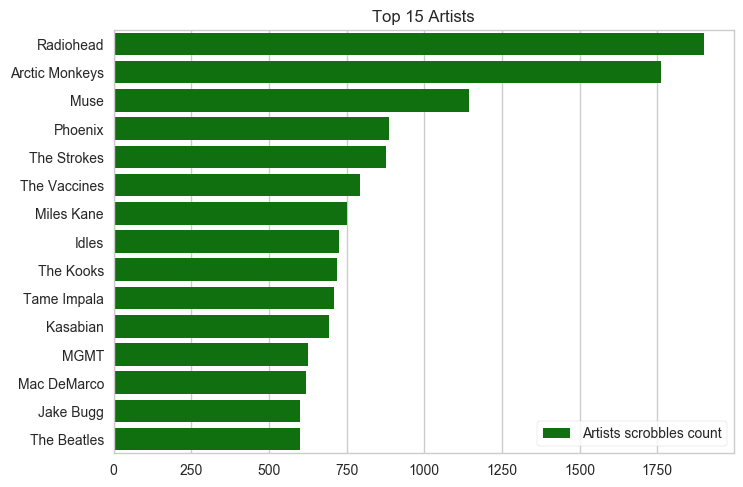

In [118]:
plot_top('artist','Top 15 Artists','Artists scrobbles count')

###### Top 15 Albums

Here's my most listened albums.

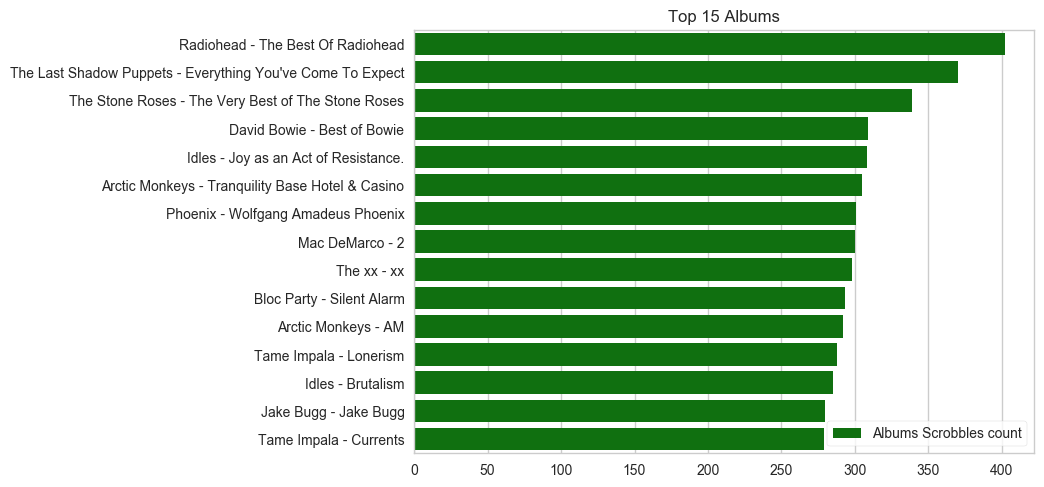

In [119]:
df['artist_album']=df['artist'] + ' - ' + df['album'] 
plot_top('artist_album','Top 15 Albums','Albums Scrobbles count')

###### Top 15 Songs

Here's my most listened songs.

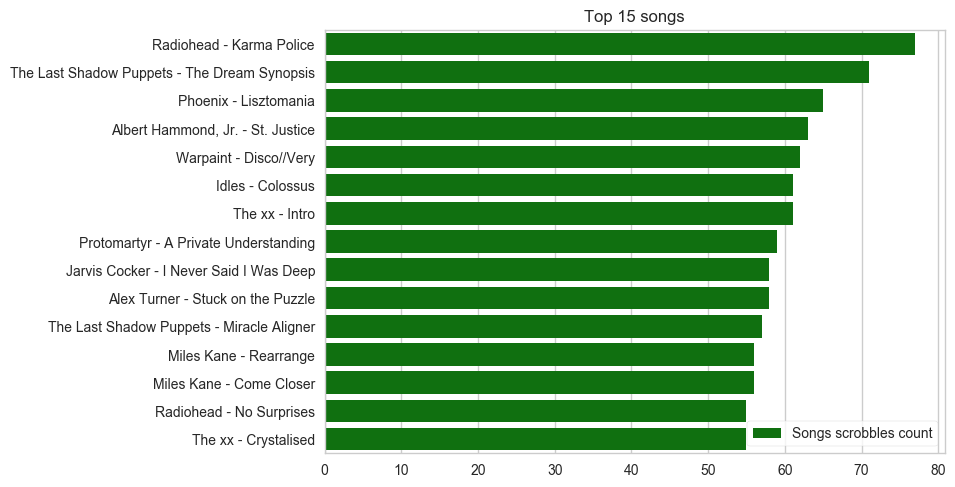

In [120]:
df['artist_song']=df['artist'] + ' - ' + df['name'] 
plot_top('artist_song','Top 15 songs','Songs scrobbles count')